# In this Jupyter notebook we will look at the associations between MLPs and other measured phenotypes in the wild isolates gathered by Jeffares et al. 2015

In [69]:
#importing standard data science libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
%matplotlib inline  
root = "/Users/bencekover/Library/CloudStorage/OneDrive-Personal/MSci Bahler lab/S.-Pombe-MLPs - Github/"


plt.rcParams["font.family"] = "Arial"

data = pd.read_excel(root + 'external data/Jeffares et al. 2015,2017/Jeffares 2015 measurements and LTRs.xlsx', sheet_name=4, header=16)
strain_clusters = pd.read_excel(root + 'external data/Jeffares et al. 2015,2017/Jeffares 2015 measurements and LTRs.xlsx', sheet_name=1, header=4)
liv_data = pd.read_csv(root + 'internal data/Liv_data_mean.csv')



#strain_clusters retain strain name and MCL cluster members without last 4 rows
strain_clusters = strain_clusters[['strain name', 'MCL cluster','substrate','date collected']]
strain_clusters = strain_clusters.iloc[:-4]

#washing data 
washing_emm = pd.read_csv(root + 'Bence folder/Image processing - Adhesion assay/wild_isolate_emm.csv')
washing_yes = pd.read_csv(root + 'Bence folder/Image processing - Adhesion assay/wild_isolate_yes.csv')
#in washing_emm rename ratio to Washing (EMM)

#keep only strain and Washing (EMM) columns
washing_emm = washing_emm[['strain', 'ratio','before_wash']]
washing_emm = washing_emm.rename(columns={'ratio':'Washing (EMM)','before_wash':'before_wash_emm'})
#in washing_yes rename ratio to Washing (yes)
washing_yes = washing_yes[['strain', 'ratio','before_wash']]
washing_yes = washing_yes.rename(columns={'ratio':'Washing (YES)','before_wash':'before_wash_yes'})
#keep only strain and Washing (yes) columns



#high-thropughput floc data /Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/Bence folder/Phenotypes/plate_reader_wild_isolates_results.csv
floc_data_emm =  pd.read_csv(root + 'Bence folder/Plate_reader_assay/plate_reader_wild_isolates_results.csv')
#rename Mean to Floc (EMM)
floc_data_emm = floc_data_emm.rename(columns={'Mean':'Floc (EMM)'})
#add strain clusters to data using strain name column in strain_clusters and strain column in data
data = data.merge(strain_clusters, left_on='strain', right_on='strain name', how='left')


#add it to data based on column strain
data = data.merge(washing_emm, on='strain', how='left')
data = data.merge(washing_yes, on='strain', how='left')
data = data.merge(floc_data_emm, left_on='strain', right_on='Strain', how='left')
data = data.merge(liv_data, left_on='strain', right_on='Sample', how='left')
#remove useless columns: strain name, Strain, SEM, Unnamed: 0
data = data.drop(columns=['strain name', 'Strain', 'SEM', 'Unnamed: 0','Sample'])

#for columns where there is smgrowth in the name, take log2
for col in data.columns:
    if 'smgrowth' in col:
        data[col] = np.log2(data[col])


#create column "sticky_yes_binary" which is 1 if Washing (YES) > 0.2
data["sticky_yes_binary"] = np.where(data["Washing (YES)"] > 0.3, 1, 0)



/Users/bencekover/opt/anaconda3/lib/python3.9/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
/Users/bencekover/opt/anaconda3/lib/python3.9/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
/Users/bencekover/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [70]:
#imputing MLP data for all strains of the same cluster
#iterate through rows of data
for index, row in data.iterrows():
      completed_clusters = []
    #check whether MCL cluster is NaN. If not keep going
      if pd.notnull(row['MCL cluster']) and row['MCL cluster'] not in completed_clusters:
            if pd.notnull(row['Washing (EMM)']):
                #find indices of all rows in the same cluster
                  cluster_indices = data[data['MCL cluster']==row['MCL cluster']].index
                  #assign the same 'Washing (EMM)' value to all rows in the same cluster
                  data.loc[cluster_indices, 'Washing (EMM)'] = row['Washing (EMM)']
                  #and 'Washing (YES)'
                  data.loc[cluster_indices, 'Washing (YES)'] = row['Washing (YES)']
                  #and 'Floc (EMM)'
                  data.loc[cluster_indices, 'Floc (EMM)'] = row['Floc (EMM)']
                  #add cluster to completed clusters
                  completed_clusters.append(row['MCL cluster'])
#remove MCL cluster column

data = data.rename(columns={'Lifespan':'Chronological Lifespan (YES)'})
#change washing to Adhesion to agar (YES)
data = data.rename(columns={'Washing (YES)':'Adhesion to agar (YES)'})

In [71]:

#cretae a function that takes data as input, and a column name, and returns the correlation coefficient pearson and spearman and p values
def correlation(data, column):
    results_df = pd.DataFrame(columns=['Pearson', 'Spearman', 'Pearson p-value', 'Spearman p-value','T_test','ANOVA_pvalue','phenotype'])
    for i in data.columns:
    #if i is not the column we are interested in and not string
        if i != column and data[i].dtype != 'O':
        #create subset of the data that is only the column and i
            subset = data[[column, i]]
            #drop inf
            subset = subset.replace([np.inf, -np.inf], np.nan)
            #remove nans
            subset = subset.dropna()
            
            #if column is string or 1/0 are the only unique values and i has more than 2 unique values
            if  len(subset[column].unique()) == 2:
                #do t-test
                T = st.ttest_ind(subset[column], subset[i],permutations=10000)
                results_df.loc[i] = [np.nan, np.nan, np.nan, np.nan, T[1], np.nan, i]
            elif data[column].dtype == 'O' and len(subset[column].unique()) > 2:
                #do anova
                for g in subset[column].unique():
                    if len(subset[subset[column]==g]) == 1:
                        subset = subset[subset[column]!=g]
                #create a list of lists
                
                subset = subset.groupby(column)[i].apply(list).reset_index(name='list')
                anova = st.f_oneway(*subset['list'])
                
            
                results_df.loc[i] = [np.nan, np.nan, np.nan, np.nan, np.nan, anova[1], i]
            else:
                #do pearson and spearman
                pearson = st.pearsonr(subset[column], subset[i])
                #do spearman
                spearman = st.spearmanr(subset[column], subset[i])
                results_df.loc[i] = [pearson[0], spearman[0], pearson[1], spearman[1], np.nan, np.nan, i]
    return results_df
corrs = correlation(data,"Adhesion to agar (YES)")
corrs = corrs.sort_values(by=['Spearman p-value'])
#corrs remove nan from spearman and then create column called fdr
corrs = corrs.dropna(subset=['Spearman p-value'])
import statsmodels.stats.multitest as smm
corrs['fdr'] = smm.multipletests(corrs['Spearman p-value'], method='bonferroni')[1]
corrs.head(50)

        

/Users/bencekover/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/bencekover/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


,Pearson,Spearman,Pearson p-value,Spearman p-value,T_test,ANOVA_pvalue,phenotype,fdr
Floc (EMM),0.495364,0.432003,3.666347e-11,1.447332e-08,NaN,NaN,Floc (EMM),0.000004
shape2.KL.Predicted.Tshape,0.083493,0.366685,2.954091e-01,1.995339e-06,NaN,NaN,shape2.KL.Predicted.Tshape,0.000615
2mM_H2O2,-0.749144,-0.544372,4.751416e-11,1.737162e-05,NaN,NaN,2mM_H2O2,0.005350
before_wash_yes,-0.499767,-0.526462,5.578691e-05,1.844641e-05,NaN,NaN,before_wash_yes,0.005681
wb.Galactose2.Efficiency,0.352472,0.470121,2.070331e-03,2.376404e-05,NaN,NaN,wb.Galactose2.Efficiency,0.007319
2percent_Glycerol_2.5g.l_NaAc,-0.496484,-0.527128,1.156326e-04,3.553415e-05,NaN,NaN,2percent_Glycerol_2.5g.l_NaAc,0.010945
smgrowth.MgCl2.0.2.M,-0.183090,-0.371899,5.016365e-02,4.269516e-05,NaN,NaN,smgrowth.MgCl2.0.2.M,0.013150
smgrowth.LiCl.10.mM,-0.135697,-0.332970,1.048707e-01,4.546284e-05,NaN,NaN,smgrowth.LiCl.10.mM,0.014003
aaconc.proline,-0.255398,-0.512639,5.518383e-02,4.563474e-05,NaN,NaN,aaconc.proline,0.014055
3mM_H2O2,-0.521352,-0.517605,4.477459e-05,5.190215e-05,NaN,NaN,3mM_H2O2,0.015986


In [72]:
corrs = correlation(data,"Adhesion to agar (YES)")
corrs = corrs.sort_values(by=['Spearman p-value'])
#corrs remove nan from spearman and then create column called fdr
corrs = corrs.dropna(subset=['Spearman p-value'])

#remove cols with names containg any of the following: rap, rapamycin, caf, caffeine, shape, h2o2, peroxide, edta
corrs = corrs[~corrs.index.str.contains('rap')]
corrs = corrs[~corrs.index.str.contains('Rap')]
corrs = corrs[~corrs.index.str.contains('caf')]
corrs = corrs[~corrs.index.str.contains('Caf')]
corrs = corrs[~corrs.index.str.contains('caffeine')]
corrs = corrs[~corrs.index.str.contains('Caffeine')]
corrs = corrs[~corrs.index.str.contains('shape')]
corrs = corrs[~corrs.index.str.contains('Shape')]
corrs = corrs[~corrs.index.str.contains('h2o2')]
corrs = corrs[~corrs.index.str.contains('H2O2')]
corrs = corrs[~corrs.index.str.contains('peroxide')]
corrs = corrs[~corrs.index.str.contains('Peroxide')]
corrs = corrs[~corrs.index.str.contains('edta')]
corrs = corrs[~corrs.index.str.contains('EDTA')]
corrs = corrs[~corrs.index.str.contains('before_wash')]
corrs = corrs[~corrs.index.str.contains('aaconc')]

#emm or EMM
corrs = corrs[~corrs.index.str.contains('emm')]
corrs = corrs[~corrs.index.str.contains('EMM')]
#floc or filametbous
corrs = corrs[~corrs.index.str.contains('floc')]
corrs = corrs[~corrs.index.str.contains('Floc')]
corrs = corrs[~corrs.index.str.contains('filamentous')]


import statsmodels.stats.multitest as smm
corrs['bonferroni'] = smm.multipletests(corrs['Spearman p-value'], method='bonferroni')[1]
corrs.head(100)

/Users/bencekover/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/bencekover/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


,Pearson,Spearman,Pearson p-value,Spearman p-value,T_test,ANOVA_pvalue,phenotype,bonferroni
wb.Galactose2.Efficiency,0.352472,0.470121,0.002070,0.000024,NaN,NaN,wb.Galactose2.Efficiency,0.005561
2percent_Glycerol_2.5g.l_NaAc,-0.496484,-0.527128,0.000116,0.000036,NaN,NaN,2percent_Glycerol_2.5g.l_NaAc,0.008315
smgrowth.MgCl2.0.2.M,-0.183090,-0.371899,0.050164,0.000043,NaN,NaN,smgrowth.MgCl2.0.2.M,0.009991
smgrowth.LiCl.10.mM,-0.135697,-0.332970,0.104871,0.000045,NaN,NaN,smgrowth.LiCl.10.mM,0.010638
wb.Maltose2.Efficiency,-0.516565,-0.446627,0.000002,0.000066,NaN,NaN,wb.Maltose2.Efficiency,0.015541
...,...,...,...,...,...,...,...,...
wb.PbNO30.4mM.Rate,0.081040,-0.254243,0.492465,0.028823,NaN,NaN,wb.PbNO30.4mM.Rate,1.000000
20mM_Lysine,-0.428292,-0.293795,0.001106,0.029474,NaN,NaN,20mM_Lysine,1.000000
wb.NaCl0.1M.Efficiency,-0.039048,-0.252615,0.741165,0.029899,NaN,NaN,wb.NaCl0.1M.Efficiency,1.000000
wb.Glycerol.growth.2.lag,-0.117678,-0.251166,0.318014,0.030884,NaN,NaN,wb.Glycerol.growth.2.lag,1.000000


In [73]:
#create a function that iterates through columns of data, and does a mann whitney between sticky and non sticky strains
def mann_whitney(data):
    #index of sticky strains sticky_yes_binary
    sticky_strains = data[data['sticky_yes_binary']==1].index
    non_sticky_strains = data[data['sticky_yes_binary']==0].index
    #results_df to have columns: measurement, mw, p-value
    results_df = pd.DataFrame(columns=['measurement', 'mw','mw_val_adjusted', 'p-value', "n_sticky", "n_non_sticky"])
    for i in data.columns:
        if i != 'sticky_yes_binary' and data[i].dtype != 'O':
            sticky = data.loc[sticky_strains, i]
            #remove nans
            sticky = sticky.dropna()
            non_sticky = data.loc[non_sticky_strains, i]
            #remove nans
            non_sticky = non_sticky.dropna()
            #if there are more than 2 unique values in sticky and non sticky
            if len(sticky.unique()) > 2 and len(non_sticky.unique()) > 2:

                mw = st.mannwhitneyu(sticky, non_sticky)
                mw_val_adjusted = mw[0]/(len(sticky)*len(non_sticky))
                results_df.loc[i] = [i, mw[0],mw_val_adjusted , mw[1], len(sticky), len(non_sticky)]
    return results_df
            


res = mann_whitney(data)
res = res.drop('Adhesion to agar (YES)', axis=0)


In [74]:
#sort by p val
res = res.sort_values(by=['p-value'])
#remove Adhesion to agar (YES)	

substrings = ['rap', 'Rap', 'caf','aaconc', 'Caf', 'Lifespan', 'lifespan', 'caffeine', 'Caffeine', 'shape', 'Shape', 'h2o2', 'H2O2', 'peroxide', 'Peroxide', 'edta', 'EDTA', 'emm', 'EMM', 'floc', 'Floc', 'filamentous']
res = res[~res.index.str.contains('|'.join(substrings))]

#add index of numbers
res['index'] = range(1,len(res)+1)
res['fdr'] = smm.multipletests(res['p-value'], method='fdr_bh')[1]
res.head(15)

#save res to .csv
res.to_csv(root + "/Bence folder/Analysis of Jeffares phenotypes/growth_vs_adhesion.csv")

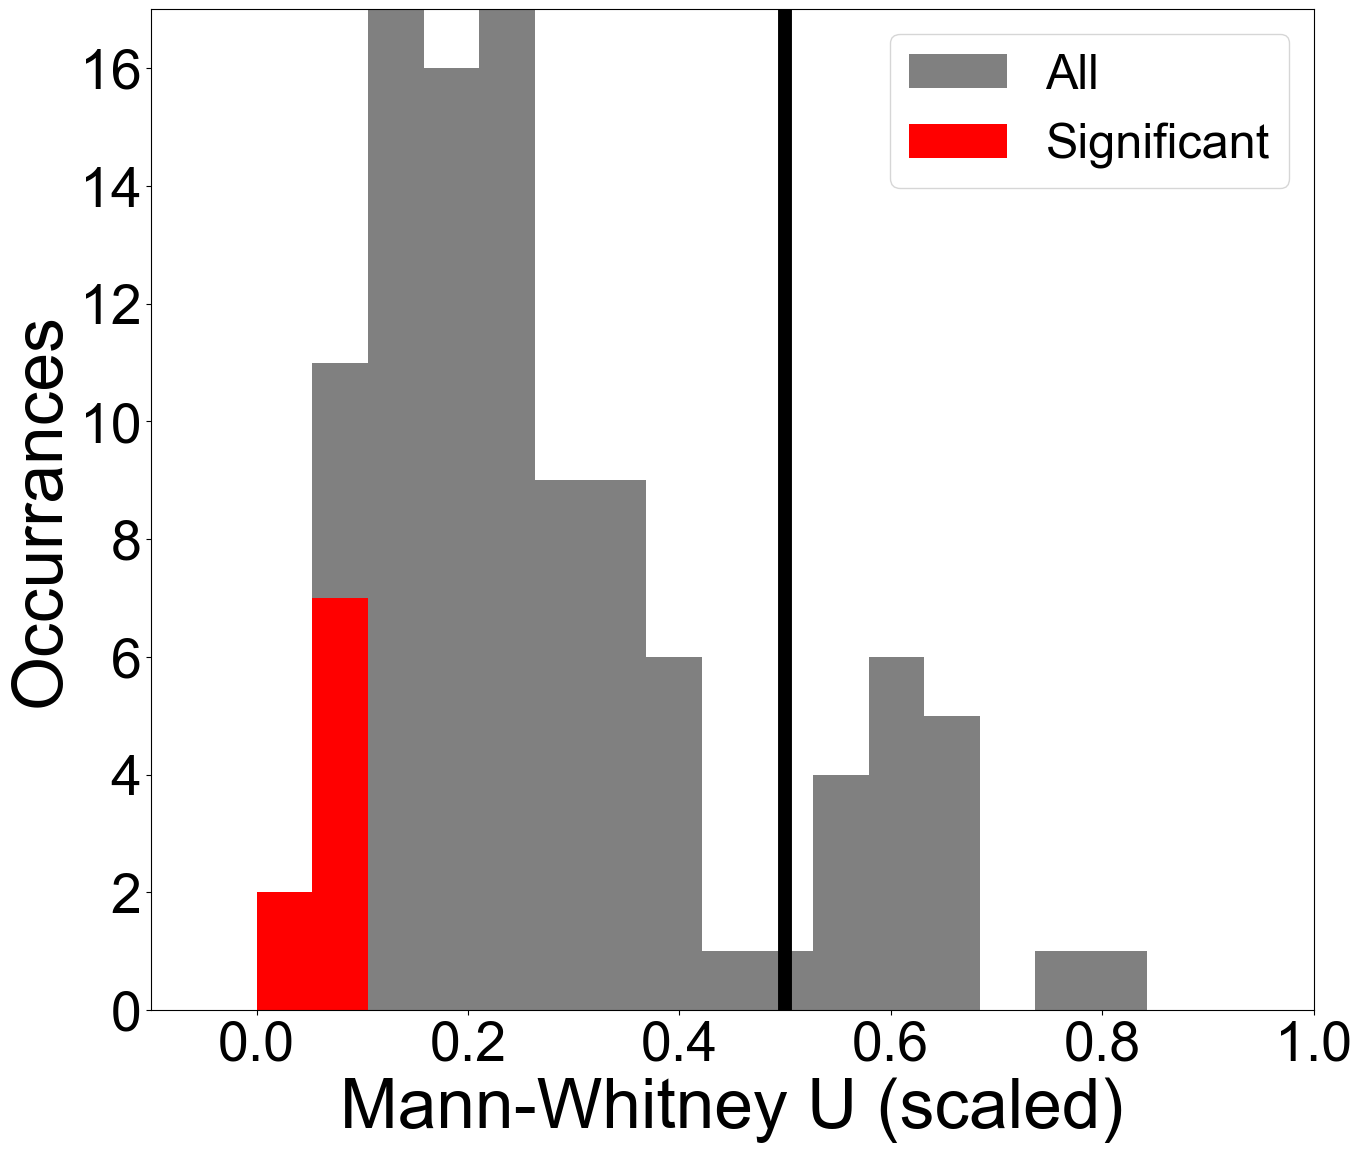

In [75]:
#large fig
plt.figure(figsize=(15,13)) 
#histogram of mw
bins = np.linspace(0, 1, 20)
plt.hist(res['mw_val_adjusted'], bins=bins, color='grey')
#histogram of subset with significant p values with same bins
plt.hist(res[res['fdr']<0.05]['mw_val_adjusted'], bins=bins, color='red')
#legends
plt.legend(['All', 'Significant'], fontsize=35, loc='upper right')
#larger legend

#labels
plt.xlabel('Mann-Whitney U (scaled)', fontsize=50)

plt.ylabel('Occurrances', fontsize=50)
#x and y axis 0 dont overlap
plt.margins(x=0, y=0)
#line at 0.5
plt.axvline(x=0.5, color='black', lw=10)
#increase size of labels and ticks
plt.tick_params(axis='both', which='major', labelsize=40)


plt.xlim(-0.1,1)
#save as svg and as png to  root + Figures/All figures
plt.savefig(root + 'Figures/All figures/Adhesion to agar (YES) mann whitney.svg', format='svg', dpi=400)

plt.savefig(root + 'Figures/All figures/Adhesion to agar (YES) mann whitney.png', format='png', dpi=400)

In [76]:

data['sticky_yes_binary_str'] = data['sticky_yes_binary']
data['sticky_yes_binary_str'] = data['sticky_yes_binary_str'].replace(1, 'Sticky')
data['sticky_yes_binary_str'] = data['sticky_yes_binary_str'].replace(0, 'Non-sticky')

/var/folders/mb/vdj4y7t13zd3tzlk99b8ycd40000gn/T/ipykernel_66550/1774312966.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[column].set_yticklabels(axs[column].get_yticks(), fontsize=55)
/var/folders/mb/vdj4y7t13zd3tzlk99b8ycd40000gn/T/ipykernel_66550/1774312966.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[column].set_yticklabels(axs[column].get_yticks(), fontsize=55)
/var/folders/mb/vdj4y7t13zd3tzlk99b8ycd40000gn/T/ipykernel_66550/1774312966.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[column].set_yticklabels(axs[column].get_yticks(), fontsize=55)


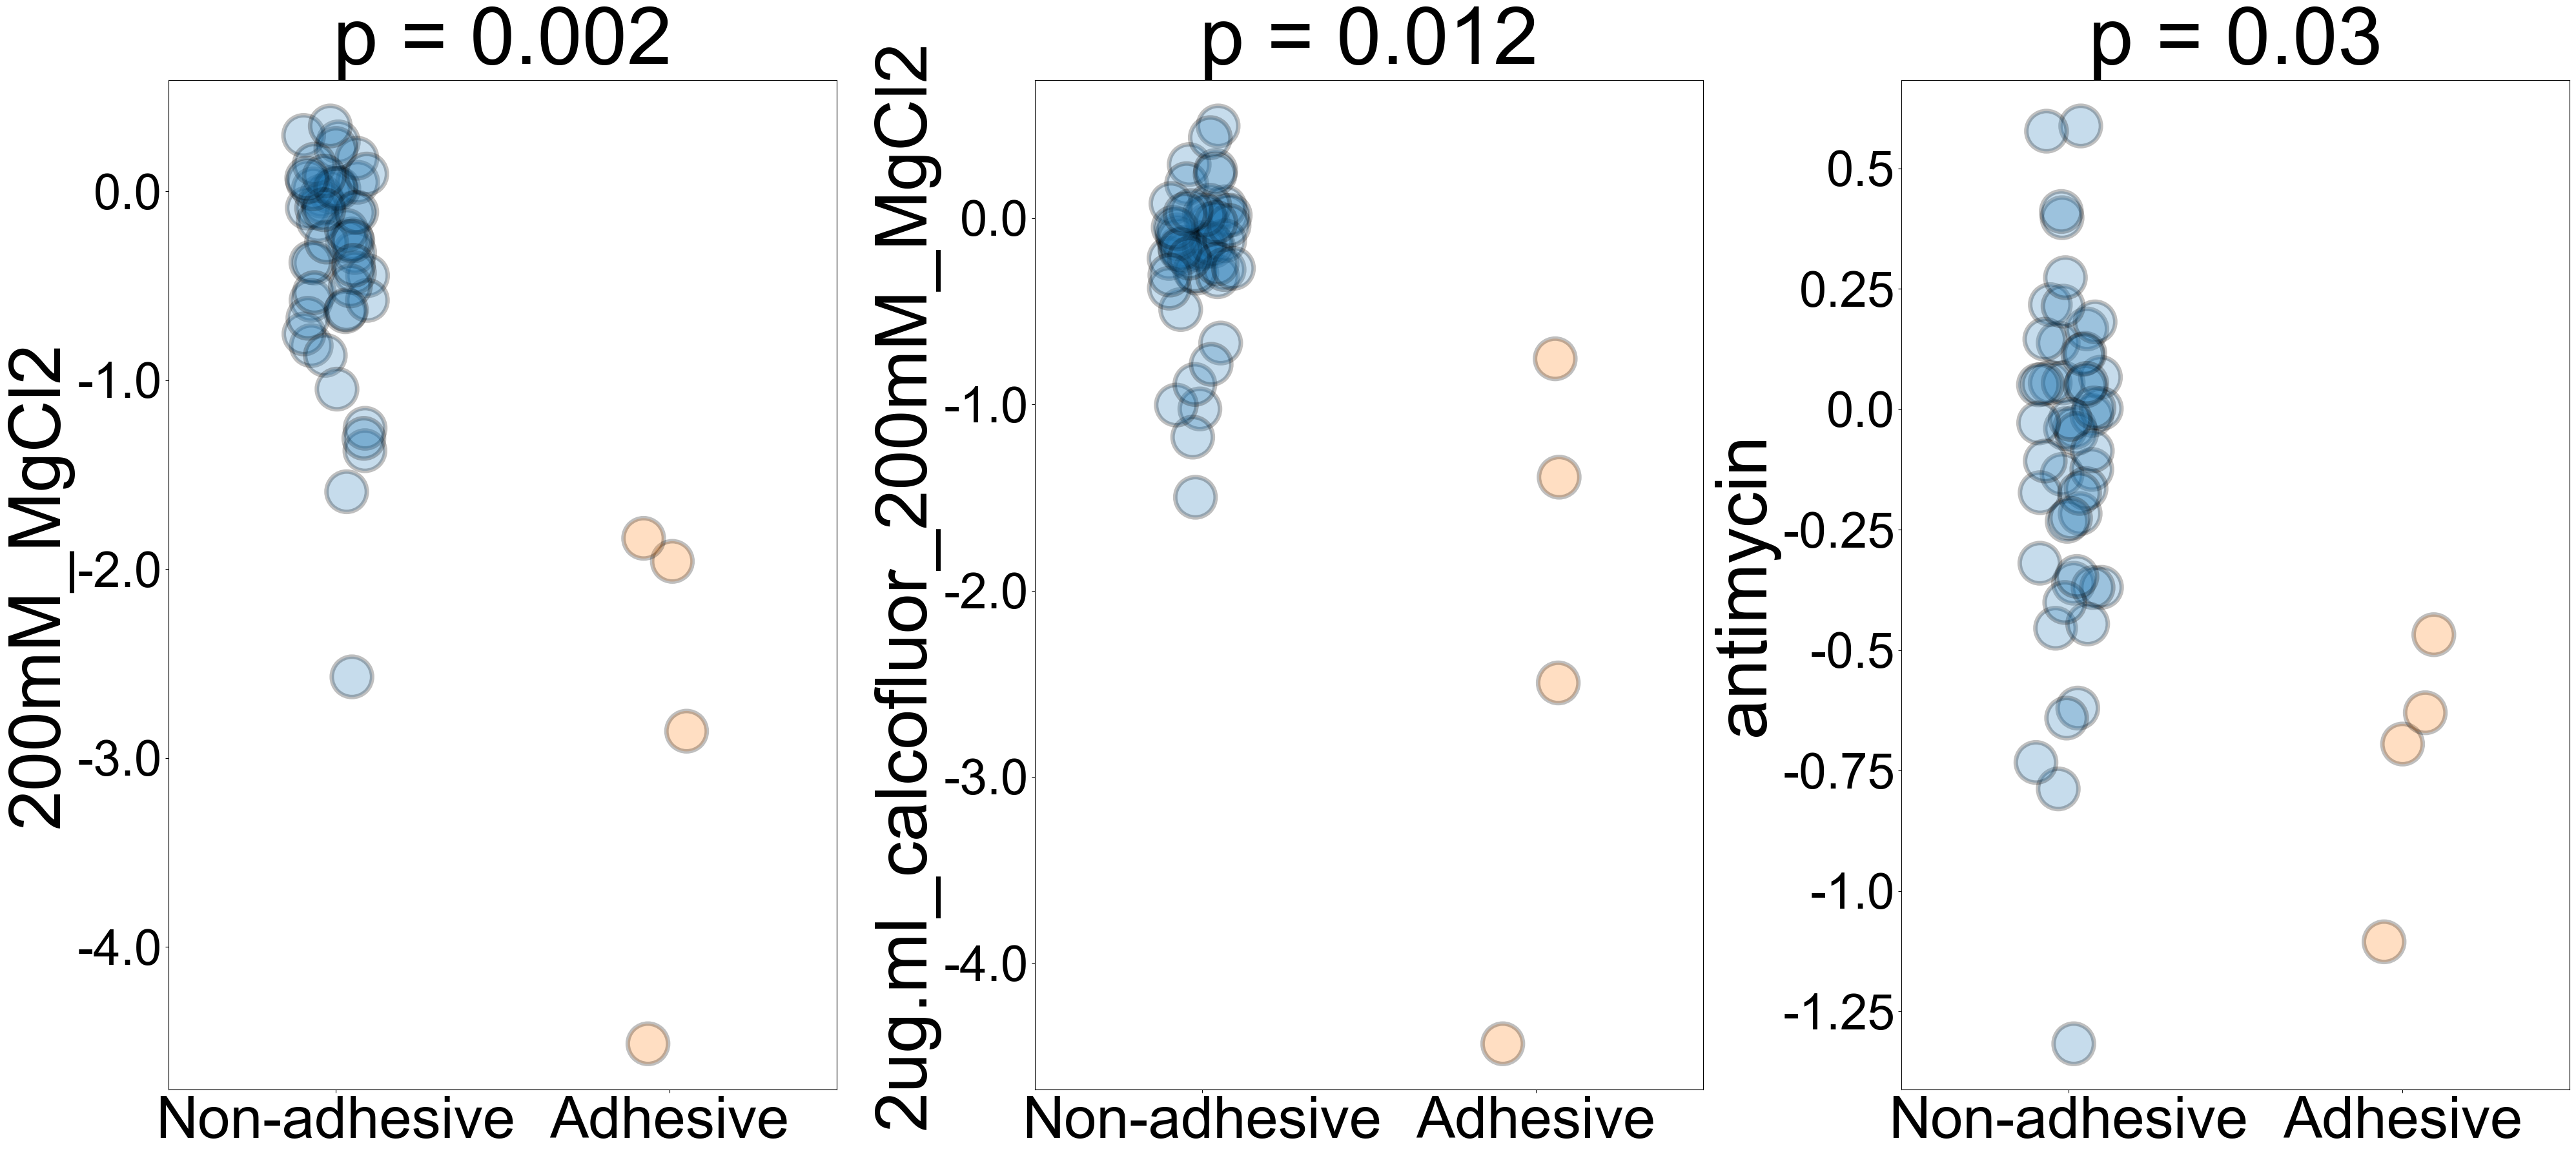

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt

# create a list of the first 3 columns in the "res" DataFrame
cols = res.head(3).measurement.tolist()

# create a figure with 3 columns in one row
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(40, 18))

# loop over the columns and create a strip plot for each one
for i, col in enumerate(cols):
    
    row = i // 3
    column = i % 3
    x_vals = data['sticky_yes_binary_str']
    y_vals = data[col]
    #sharp edges
    sns.stripplot(x=x_vals, y=y_vals, ax=axs[column],size=45,alpha=0.25, edgecolor='black', linewidth=5)
    #title is adjusted p value
    axs[column].set_title('p = ' + str(round(res.loc[col, 'fdr'], 3)),fontsize=90)
    #x axis label
    axs[column].set_xlabel('')
    #y axis label
    axs[column].set_ylabel(col, fontsize=80)
    #x ticks
    axs[column].set_xticklabels(['Non-adhesive', 'Adhesive'], fontsize=65)
    #y ticks
    axs[column].set_yticklabels(axs[column].get_yticks(), fontsize=55)
    
    

# remove the unused axes
for i in range(len(cols), 3):
    row = i // 3
    col = i % 3
    fig.delaxes(axs[col])

# adjust the layout and save the plot
fig.tight_layout()
#save as svg and as png to  root + Figures/All figures
plt.savefig(root + 'Figures/All figures/Adhesion to agar (YES) stripplot.svg', format='svg', dpi=400)
plt.savefig(root + 'Figures/All figures/Adhesion to agar (YES) stripplot.png', format='png', dpi=400)


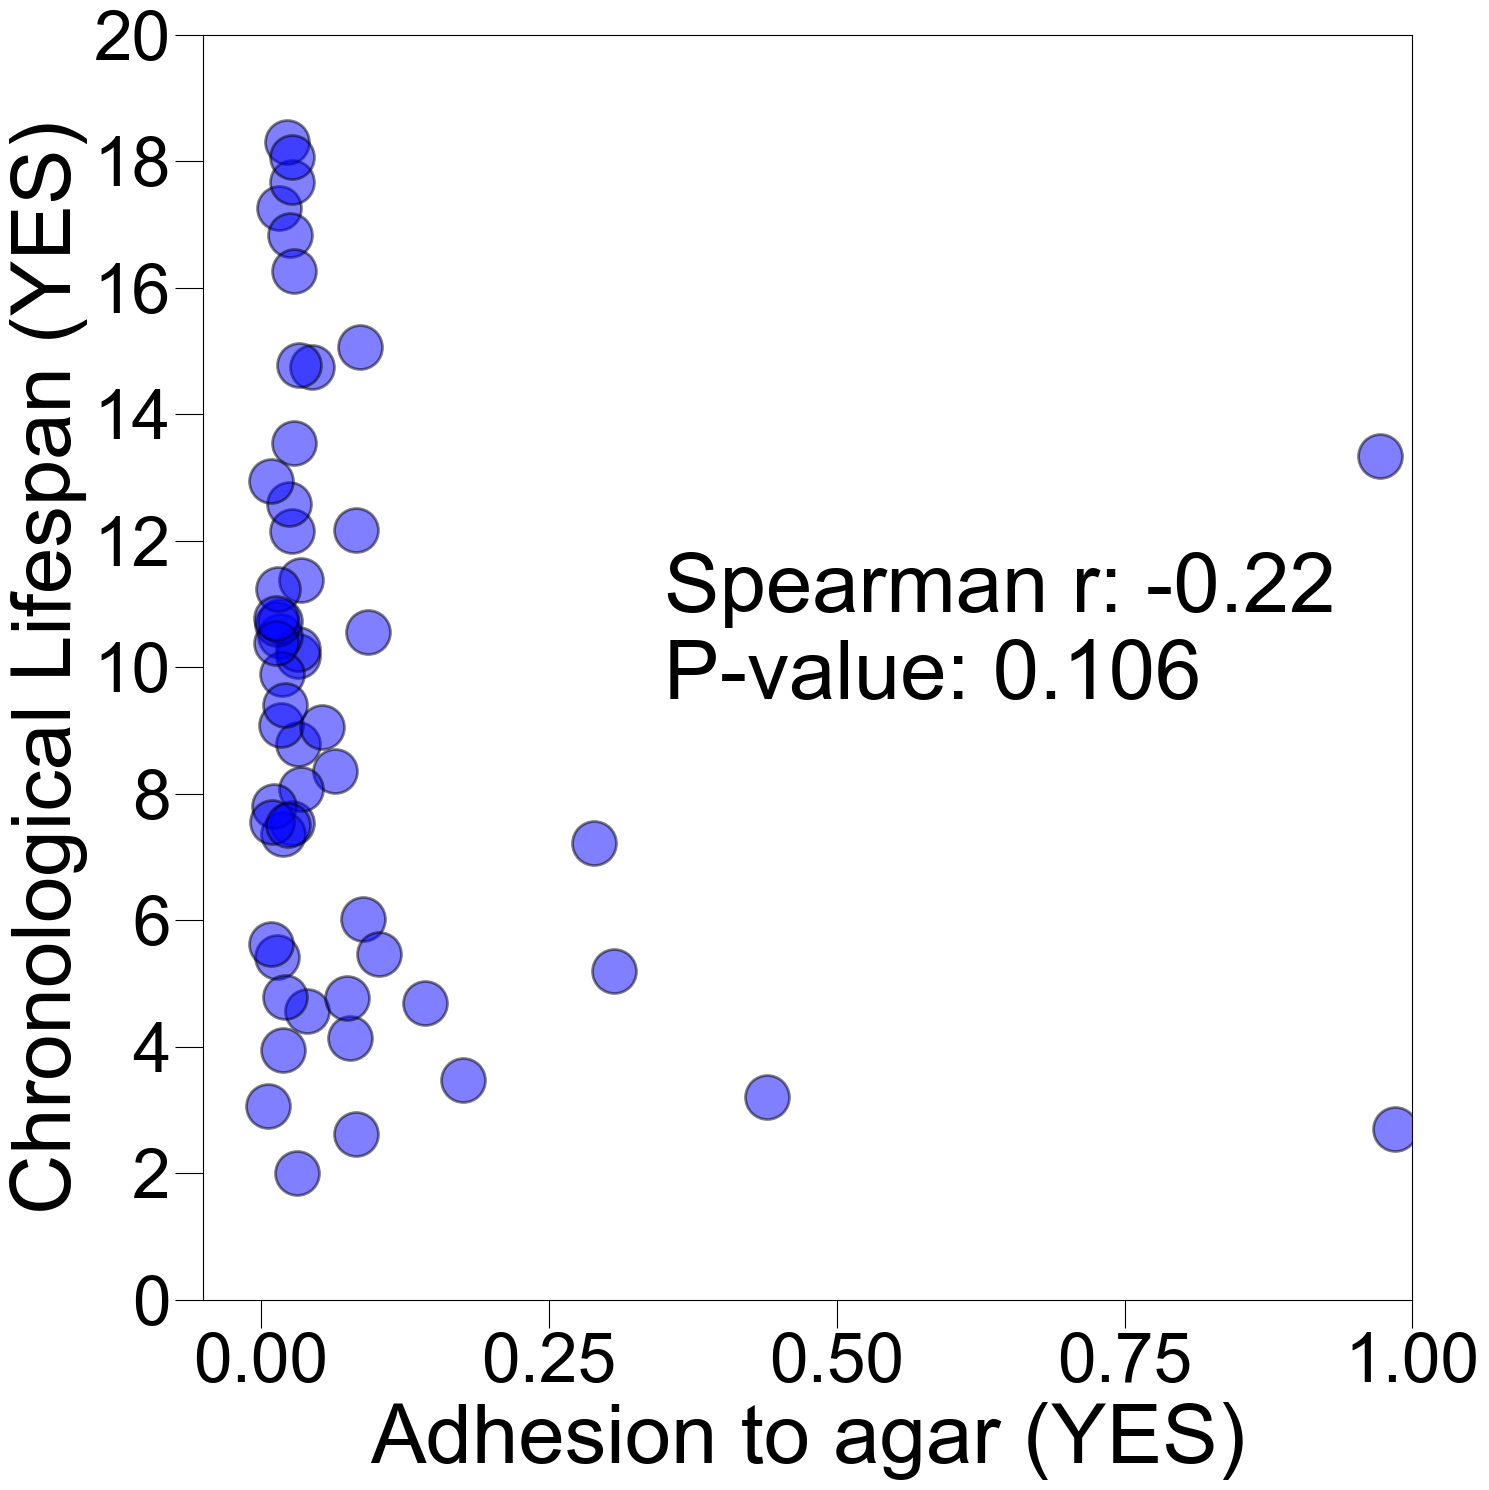

In [ ]:
#large fig
#change Lifespan to Chronological Lifespan (YES)

fig,ax = plt.subplots(figsize=(15,15))
#edges
sns.scatterplot(x='Adhesion to agar (YES)', y='Chronological Lifespan (YES)', data=data, s=1000, color='Blue', alpha=0.5, edgecolor='black', linewidth=2)
#y axis 0 - 20 with 10 ticks
plt.ylim(0,20)
plt.yticks(np.arange(0, 21, 2))
#x axis 0 - 1 with 10 ticks
plt.xlim(-0.05,1)
#larger tick lines
plt.tick_params(axis='both', which='major', labelsize=50, size=20)
#large axis labels
plt.xlabel('Adhesion to agar (YES)', fontsize=60)
plt.ylabel('Chronological Lifespan (YES)', fontsize=60)
#print spearman correlation coefficient and p value on the plot
#create subset df without nans in these two columns
subset = data[['Adhesion to agar (YES)', 'Chronological Lifespan (YES)']]
subset = subset.replace([np.inf, -np.inf], np.nan)
subset = subset.dropna()


#round to 3 digits
plt.text(0.35, 9.5, 'Spearman r: ' + str(round(st.spearmanr(subset['Adhesion to agar (YES)'], subset['Chronological Lifespan (YES)'])[0],3)) + '\n' + 'P-value: ' + str(round(st.spearmanr(subset['Adhesion to agar (YES)'], subset['Chronological Lifespan (YES)'])[1],3)), fontsize=60)
#tight
plt.tight_layout()
#save as svg and as png to  root + Figures/All figures
plt.savefig(root + 'Figures/All figures/Adhesion to agar (YES) vs Chronological Lifespan (YES) jointplot.svg', format='svg', dpi=400)
plt.savefig(root + 'Figures/All figures/Adhesion to agar (YES) vs Chronological Lifespan (YES) jointplot.png', format='png', dpi=400)
    

In [ ]:
%load_ext watermark
%watermark -v -p numpy,pandas,scipy,bokeh,iqplot,bebi103,jupyterlab

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.9.0
IPython version      : 7.31.1

numpy     : 1.21.6
pandas    : 1.4.4
scipy     : 1.7.3
bokeh     : 2.4.0
iqplot    : 0.3.3
bebi103   : 0.1.11
jupyterlab: 3.5.3

